In [1]:
import lppydsmc.poisson_solver as ps
import numpy as np
from fenics import * # for plotting

import os
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["NUMEXPR_NUM_THREADS"] = "1" 
os.environ["OMP_NUM_THREADS"] = "1" 

# A first example

In [2]:
in_vertices = np.array([[0,0],[1,0],[1,1],[0,1]]) 
out_vertices_list = [np.array([[0.25, 0.5],[0.5,0.25],[0.75,0.5],[0.5,0.75]])] # list of all polygones to remove
mesh = ps.mesh.polygonal(resolution = 10, in_vertices = in_vertices, out_vertices_list = out_vertices_list)

In [3]:
# poisson solver 

# boundary conditions
boundary_conditions = { 
                'top' : {
                    'type' : 'Dirichlet',
                    'solution' : '1 + x[0]*x[0] + 2*x[1]*x[1]', # 2D, x[1] = 'x', x[2] = 'y' for example.
                    'solution_kwargs' : {},
                    'degree' : 2,
                    'boundary' : 'on_boundary && near(x[1], 1, tol)', # must return a boolean
                                                                      # on_boundary corresponds to a boolean fenics returns, because it knows in practice if *x* is on the boundary or not.
                                                                      # *near(x[0], 1, tol)* is equivalent to *abs(x[0]-1)<tol*
                    'boundary_kwargs' : {
                        'tol' : 1e-14
                    }               
                },
                'bottom' : {
                    'type' : 'Dirichlet',
                    'solution' : 'x[0] <= 0.5 + tol ? k_0 : k_1',
                    'solution_kwargs' : {
                        'k_0' : 1.0,
                        'k_1' : 0.01,
                        'tol' : 1e-14
                    },
                    'degree' : 0,
                    'boundary' : 'on_boundary && near(x[1], 0, tol)',
                    'boundary_kwargs' : {
                        'tol' : 1e-14
                    }
                }
            }
# charge density
charge_density = {
                'value' : 'max_density-x[0]*(max_density-min_density)/lx',  # must be a string too
                'degree' : 2,
                'kwargs' : {
                    'max_density' : 2e17,
                    'min_density' : 1e17,
                    'lx' : 1.0 # size of the system - no offset
                } 
            }

In [6]:
potential_field, electric_field = ps.solver(mesh, boundary_conditions, charge_density) 

## Can we reproduce previous results on the thruster ?

In [6]:
import lppydsmc as ld
dp = 0.001  

# here, x : l, y : w
dict_thruster = {
    'w_in' : 5*dp,
    'l_in' : 3*dp,
    'w_1' : 3*dp,
    'l_1' : dp,
    'l_int' : dp,
    'w_2' : dp,
    'l_2' : 10*dp,
    'w_out' : 5*dp,
    'l_out' : dp,
    'offsets' : np.array([0,0]) 
}
# Note:  l_mot = l_in 
in_vertices = np.flip(ld.systems.helper.thruster_points(**dict_thruster), axis = 0)
mesh = ps.mesh.polygonal(resolution = 100, in_vertices = in_vertices)

In [7]:
tol = 1e-14

# useful lenghts to define boundary conditions
x_in = dict_thruster['offsets'][0]
x_electrode_1 = x_in + dict_thruster['l_in']
x_inter_electrodes_area = x_electrode_1 + dict_thruster['l_1']
x_electrode_2 = x_inter_electrodes_area + dict_thruster['l_int']
x_out = x_electrode_2 + dict_thruster['l_2']

In [8]:
# poisson solver 

potential_boundary_conditions = {
    'inflow_area' : '0.0',
    'inflow_area_sides': 'Neumann',
    'electrode_1' : '30.0',
    'inter_electrode_area':'Neumann',
    'electrode_2': '300.0'
}

# boundary conditions
boundary_conditions = {
                'inflow_area' : {
                    'type' : 'Dirichlet',
                    'solution' : potential_boundary_conditions['inflow_area'], 
                    'solution_kwargs' : {},
                    'degree' : 0, # because constant
                    'boundary' : 'on_boundary && near(x[0], x_in, tol)', 
                    'boundary_kwargs' : {
                        'tol' : tol,
                        'x_in' : x_in
                    }               
                },
                'inflow_area_sides' : {
                    'type' : 'Neumann'
                },
                'electrode_1' : {
                    'type' : 'Dirichlet',
                    'solution' : potential_boundary_conditions['electrode_1'], 
                    'solution_kwargs' : {},
                    'degree' : 0,
                    'boundary' : 'on_boundary && x[0] > x_electrode_1 - tol && x[0] < x_inter_electrodes_area + tol',
                    'boundary_kwargs' : {
                        'tol' : tol,
                        'x_electrode_1' : x_electrode_1,
                        'x_inter_electrodes_area' : x_inter_electrodes_area
                    }
                },
                'inter_electrode_area' : {
                    'type' : 'Neumann'
                },
                'electrode_2' : {
                    'type' : 'Dirichlet',
                    'solution' : potential_boundary_conditions['electrode_2'], 
                    'solution_kwargs' : {},
                    'degree' : 0,
                    'boundary' : 'on_boundary && x[0] > x_electrode_2 - tol && x[0] < x_out + tol',
                    'boundary_kwargs' : {
                        'tol' : tol,
                        'x_electrode_2' : x_electrode_2,
                        'x_out' : x_out
                    }
                }
            }
# charge density
charge_density = {
                'value' : '0',  # must be a string too
                'degree' : 0,
                'kwargs' : {}
            }

In [9]:
potential_field, electric_field = ps.solver(mesh, boundary_conditions, charge_density) 

In [10]:
import matplotlib.pyplot as plt

E = electric_field
Phi = potential_field

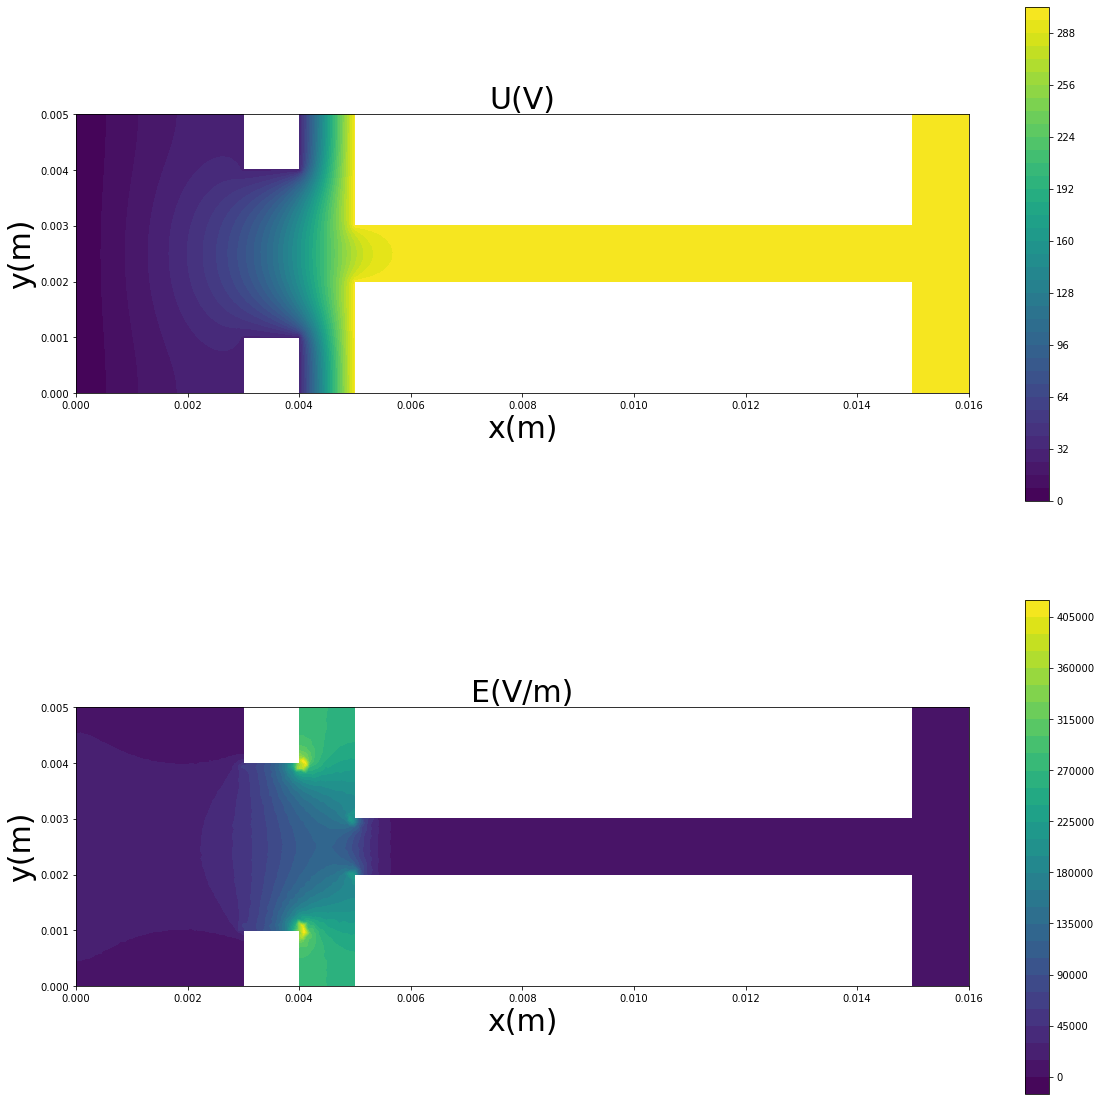

In [11]:
Ex, Ey = E.split(deepcopy=True)
NE=sqrt(dot(E,E))

plt.figure(figsize=(20,20))

plt.subplot(2,1,1)
fig=plot(Phi)
plt.title('U(V)', size=30)
fig.set_cmap("viridis") 
plt.colorbar(fig)
plt.xlabel('x(m)', size=30)
plt.ylabel('y(m)', size=30)

plt.subplot(2,1,2)
fig=plot(NE)
plt.title('E(V/m)', size=30)
fig.set_cmap("viridis") 
plt.colorbar(fig)
plt.xlabel('x(m)', size=30)
plt.ylabel('y(m)', size=30)

plt.show()